<h1> ______________________________________ </h1>

<h1> Full NEXT100 with fiber panels simulation mapping analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we analyse the results from the MC decays of Kr38m and bb0nu events simulated in a "realistic" fiber barrel. A mapping of the signal depending on the spatial position is perfomed in the XY plane and Z-axis and then used to determine the energy resolution at Krypton's decay energy. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100 Kr38m S1 events. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

<h1> _________________________________________________________________________________________________________ </h1>


<h1> __________________________ </h1>
<h2> Functions </h2>

-  <p style="font-size: 17px; color: black;"> <b> gauss(x, a,  mu, sigma): </b> Gaussian normalized to $a$. </p>


-  <p style="font-size: 17px; color: black;"> <b> gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1): </b> Sum of 2 gaussians. </p>


-  <p style="font-size: 17px; color: black;"> <b> dirac(x, x0): </b> Dirac delta at $x0$. </p>




In [2]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    
    return (a/gaussian.sum())*gaussian

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

def dirac(x, x0):
    return np.where((x - x0) == 0, 1, 0)


<h1> __________________________ </h1>
<h2> Global parameters </h2>

-  <p style="font-size: 17px; color: black;"> <b> Pandas dataset params: </b> Allows to set the max number of columns and rows that are shown in a pandas dataset. </p>

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 20)

-  <p style="font-size: 17px; color: black;"> <b> Plots params: </b> In case you want to fix the parameters for all plots. </p>

In [4]:
# plt.rcParams["figure.figsize"] = 10, 8
# plt.rcParams["font.size"] = 10

-  <p style="font-size: 17px; color: black;"> <b> Analysis parameters </b> </p>



In [5]:
dark25 = 2000 # [Kcps] (1Kcps = 1e3 dark pulses per second) DCR at 25ºC
x_talk = 7 # [%] Probability of a dark count to be 2pe instead of 1pe
n_sensors = 90 
t_binning = 0.1 # [ns] Conversion constant from bin enumerations to nanoseconds (binning used in the simulation)
dT = 5.3 # [ºC] Decay factor at which the dark rate halves

In [6]:
yield_ = 1050 # ph/e⁻
# yield_ = 2000 # ph/e⁻


<h1> __________________________ </h1>
<h2> Data </h2>

-  <p style="font-size: 17px; color: black;"> <b> Reading the file </b> </p>

-  <p style="font-size: 17px; color: black;"> File's path </p>

In [7]:
# path = '/home/investigator/mariandbt/nexus'
# filename = os.path.join(path, "Next100_full.next.h5")

path = '/home/investigator/mariandbt/python/data/'
# # path = path + '/20230921_NEXT100_full_fiber_barrel'
path = path + '/20231025_NEXT100_full_mapping'

# filename = os.path.join(path, "Next100_full_Kr_noEL_10Kev.next.h5")
# filename = os.path.join(path, "Next100_full_mapp_s2_mitadActive_10Kev.next.h5")
# filename = os.path.join(path, "Next100_full_mapp_s2_inicioEL_10Kev.next.h5")
filename = os.path.join(path, "Next100_full_mapp_s2_inicioEL_100Kev.next.h5")

# filename = os.path.join(path, "Next100_full_Kr_noEL_100ev.next.h5")
# filename = os.path.join(path, "Next100_full_Kr_1event.next.h5")
# filename = os.path.join(path, "Next100_full_Kr_noEL_100ev.next.h5")
# filename = os.path.join(path, "Next100_full_Kr_noEL_100ev_sensName.next.h5")
# filename = os.path.join(path, "Next100_full_Kr_noEL_20ev.next.h5")


-  <p style="font-size: 17px; color: black;"> In a .h5 file there are several objects, so we print them all to then pick the one we're interested in </p>

In [8]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/python/data//20231025_NEXT100_full_mapping/Next100_full_mapp_s2_inicioEL_100Kev.next.h5 (File) ''
Last modif.: '2023-11-14T11:00:27+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(49,)) ''
/MC/hits (Table(0,)) ''
/MC/particles (Table(100000,)) ''
/MC/sns_positions (Table(3524,)) ''
/MC/sns_response (Table(1455365,)) ''



-  <p style="font-size: 17px; color: black;"> Read the file and make a copy to work with, this way it's easier to re-start the copy instead of re-reading the file. </p>

In [9]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
particles = pd.read_hdf(filename, "/MC/particles")
sensors = pd.read_hdf(filename, "/MC/sns_positions")
data = pd.read_hdf(filename, "/MC/sns_response")


In [10]:
dst_particle = particles.copy()
sens = sensors.copy()
dst = data.copy()


In [11]:
dst_particle
len(dst_particle.loc[(dst_particle.creator_proc == "Electroluminescence")])
# dst_particle.loc[(dst_particle.creator_proc == "Electroluminescence")]

0

In [12]:
sens

,sensor_id,sensor_name,x,y,z
0,222,F_SENSOR,2.842171e-14,482.558960,8.225000
1,203,F_SENSOR,4.811318e+02,50.312019,8.225000
2,273,F_SENSOR,1.330953e+02,-465.085785,8.225000
3,204,F_SENSOR,4.870359e+02,16.828556,8.225000
4,240,F_SENSOR,-4.870359e+02,16.828556,8.225000
5,200,F_SENSOR,4.634197e+02,150.762405,8.225000
6,266,F_SENSOR,3.400000e+01,-482.558960,8.225000
7,201,F_SENSOR,4.693238e+02,117.278946,8.225000
8,289,F_SENSOR,4.634197e+02,-150.762405,8.225000
9,264,F_SENSOR,-2.289440e+02,-430.199707,8.225000


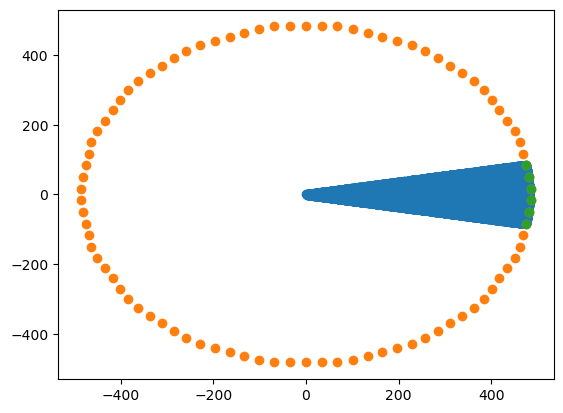

In [13]:
plt.plot(dst_particle.initial_x, dst_particle.initial_y, 'o')

fib_sens = sens.loc[sens.sensor_name == "F_SENSOR"]
plt.plot(fib_sens.x, fib_sens.y, 'o')

sector_sens = fib_sens.loc[(fib_sens.y > dst_particle.initial_y.min() - 10) &
                           (fib_sens.y < dst_particle.initial_y.max() + 10) &
                           (fib_sens.x > 0.)
                          ]
plt.plot(sector_sens.x, sector_sens.y, 'o')

plt.show()

In [14]:
sector_sens

,sensor_id,sensor_name,x,y,z
1,203,F_SENSOR,481.131836,50.312019,8.225
3,204,F_SENSOR,487.035889,16.828556,8.225
31,287,F_SENSOR,475.227814,-83.795486,8.225
32,285,F_SENSOR,487.035889,-16.828556,8.225
33,286,F_SENSOR,481.131836,-50.312019,8.225
34,202,F_SENSOR,475.227814,83.795486,8.225


In [15]:
dst_particle.initial_y.min()

-83.23578643798828

<h1> __________________________ </h1>
<h2> Analysis </h2>

In [16]:
dst_particle.initial_z.unique()

array([596.425], dtype=float32)

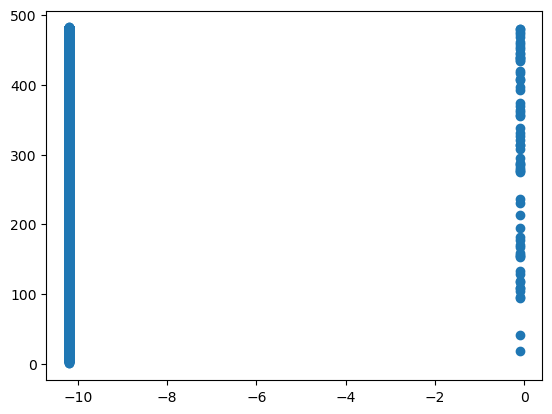

In [17]:
plt.plot(dst_particle.final_z, dst_particle.final_x, 'o')
plt.show()

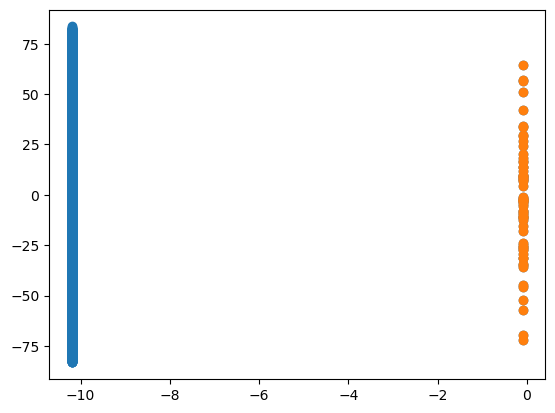

In [20]:
plt.plot(dst_particle.final_z, dst_particle.final_y, 'o')
plt.plot(dst_particle.loc[dst_particle.final_z > -2].final_z, 
         dst_particle.loc[dst_particle.final_z > -2].final_y, 'o')
plt.show()

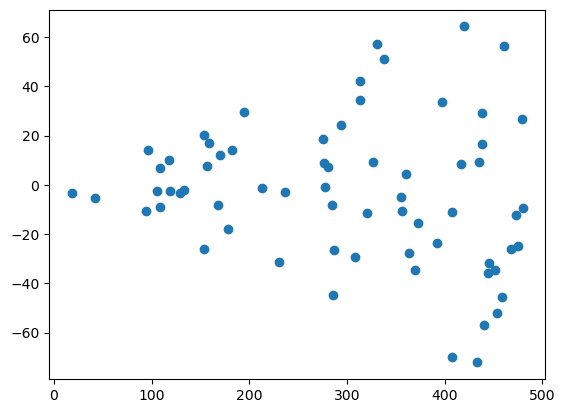

In [19]:
plt.plot(dst_particle.loc[dst_particle.final_z > -2].final_x, 
         dst_particle.loc[dst_particle.final_z > -2].final_y, 'o')
plt.show()

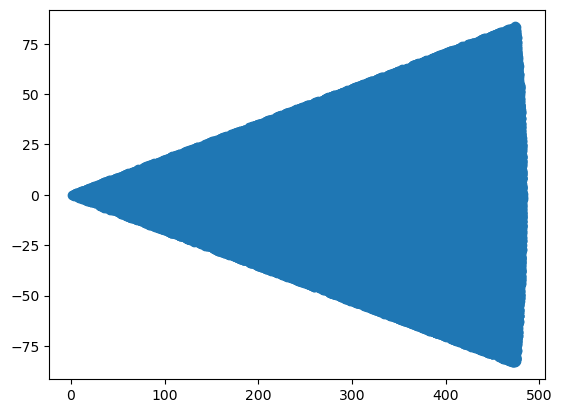

In [82]:
plt.plot(dst_particle.final_x, dst_particle.final_y, 'o')
plt.show()

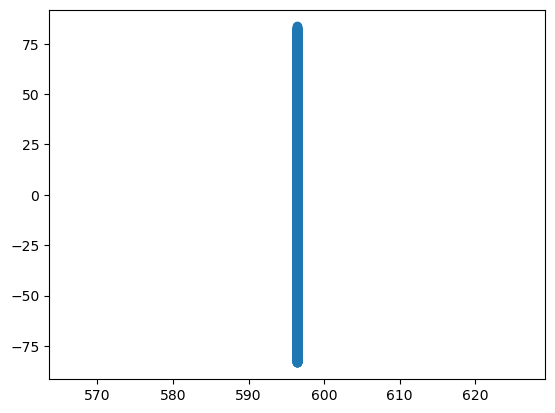

In [83]:
plt.plot(dst_particle.initial_z, dst_particle.initial_y, 'o')
plt.show()

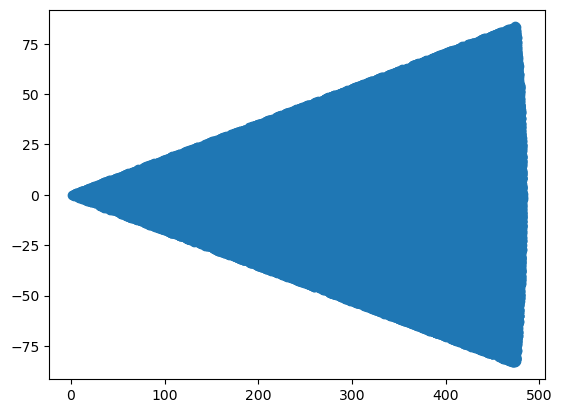

In [84]:
plt.plot(dst_particle.initial_x, dst_particle.initial_y, 'o')
plt.show()

In [85]:
dst_particle.initial_y.min()

-83.23578643798828

In [86]:
dst.time_bin = dst.time_bin*t_binning # change units to ns

In [87]:
n_events = dst_particle.event_id.max() + 1 # save number of events simulated

# *** OJO AQUII!!

In [99]:
# we select the response of the sensors at the end of the fibers

fiber_sens_mask = sens.loc[sens.sensor_name == 'F_SENSOR'].sensor_id # ID mask of the sensors at the end of the fibers

dst_fibers = dst.loc[dst.sensor_id.isin(fiber_sens_mask)] # dst only for the sensor on the fibers
sens_fibers = sens.loc[sens.sensor_id.isin(fiber_sens_mask)] # get the positions of said sensors


In [124]:
sens_fibers.sensor_id.unique()
pp = dst_fibers.loc[dst_fibers.event_id == 1000]

pp, len(pp.sensor_id.unique())
dst_fibers.groupby("event_id").size().mean()

13.7968659315148

In [126]:
len(sens_fibers.sensor_id.unique())

90

In [89]:
# keep track of the events with no counts
no_counts_events = set(range(n_events)) - set(dst_fibers.event_id.unique()) 
print(f'Events {no_counts_events} did not have any counts')

# Create a DataFrame with all event IDs
all_event_ids = pd.DataFrame({'event_id': range(n_events)})

# Merge the two DataFrames to align charge values
dst_fibers = all_event_ids.merge(dst_fibers, on='event_id', how='left').fillna(0)


Events {27648, 41216, 48385, 23814, 31366, 48774, 33545, 43785, 55436, 89230, 91151, 85008, 1554, 52882, 92948, 57496, 70682, 60446, 38048, 52516, 13861, 79654, 32552, 53162, 81579, 85930, 46637, 65070, 77229, 20784, 2225, 4916, 75316, 51511, 17082, 64123, 74048, 35779, 44485, 94149, 67144, 46025, 68810, 81612, 51534, 72147, 72531, 58839, 73561, 40540, 25437, 55134, 46176, 92259, 12537, 3687, 26858, 86379, 86514, 31604, 45556, 32759, 67960, 16249, 24443, 59902} did not have any counts


In [90]:
event_charge = dst_fibers.groupby("event_id").charge.sum() # total charge detected on each event

In [183]:
dst_fibers

,event_id,sensor_id,time_bin,charge
0,0,222,597734.1,1
1,0,203,599702.3,1
2,0,273,598573.6,1
3,0,204,597565.2,1
4,0,240,596937.8,1
5,0,200,598285.2,1
6,0,266,599763.9,1
7,0,201,599966.8,1
8,0,289,599666.7,1
9,0,264,599441.7,1


# *** 

- <p style="font-size: 17px; color: black;"> <b> Save the coordinates of each event: </b> Since the initial coordinates are the same for all primary particles in the event we need to only save the 1st. </p>

In [91]:
ev_x0 = dst_particle.loc[dst_particle.primary == 1].groupby("event_id").initial_x.first()
ev_y0 = dst_particle.loc[dst_particle.primary == 1].groupby("event_id").initial_y.first()
ev_z0 = dst_particle.loc[dst_particle.primary == 1].groupby("event_id").initial_z.first()

In [92]:
len(ev_x0), len(event_charge)

(100000, 100000)

- <p style="font-size: 17px; color: black;"> <b> Map the charge vs positon hists: </b> Map in XY with a 2D histogram and in Z-axis with a 1D histogram. </p>

In [176]:
# n_bins = int(np.sqrt(n_events))
n_bins = 20

bin_width = 10 # [mm]
x_nbins = int((ev_x0.max() - ev_x0.min())/bin_width)
y_nbins = int((ev_y0.max() - ev_y0.min())/bin_width)
# x_nbins = y_nbins = n_bins
bins = (x_nbins, y_nbins)

# bins = (20, 50)
font_size = 11
offset = 0.

In [177]:
# XY-plane

# Create a 2D histogram
hist, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
                                      bins=bins, 
                                      weights = event_charge,
                                      density=False);

hist_counts, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
                                             bins=bins, 
                                             density=False);

# Calculate the mean values in each bin (normalized histogram)
hist_norm = np.where(hist_counts > 0., hist / hist_counts, 0.);


/tmp/ipykernel_549914/1926091879.py:14: RuntimeWarning: invalid value encountered in true_divide
  hist_norm = np.where(hist_counts > 0., hist / hist_counts, 0.);


In [178]:

# Initialize lists to store statistics for each bin
mean_per_bin = np.zeros((x_nbins, y_nbins))
std_per_bin = np.zeros((x_nbins, y_nbins))
entries_per_bin = np.zeros((x_nbins, y_nbins))
mean_per_bin_err = np.zeros((x_nbins, y_nbins))

# Iterate over each bin
for i in range(x_nbins):
    for j in range(y_nbins):
        # Indices of data points in the current bin
        mask = ((ev_x0 >= xedges[i]) & (ev_x0 < xedges[i + 1]) & 
                (ev_y0 >= yedges[j]) & (ev_y0 < yedges[j + 1]))
        
        # Extract values and weights in the current bin
        values_in_bin = event_charge[mask]
        
        # Calculate weighted mean and standard deviation
        mean_value = np.mean(values_in_bin)
        std_value = np.std(values_in_bin)
        entries_value = len(values_in_bin)

        # Append to lists
        mean_per_bin[i][j] = mean_value
        std_per_bin[i][j] = std_value
        entries_per_bin[i][j] = entries_value
        mean_per_bin_err[i][j] = np.where(entries_value*mean_value> 0., 
                                          std_value*100/(np.sqrt(entries_value)*mean_value), 
                                          0.)
        
mean_per_bin = np.nan_to_num(mean_per_bin)
std_per_bin = np.nan_to_num(std_per_bin)
entries_per_bin = np.nan_to_num(entries_per_bin)
mean_per_bin_err = np.nan_to_num(mean_per_bin_err)

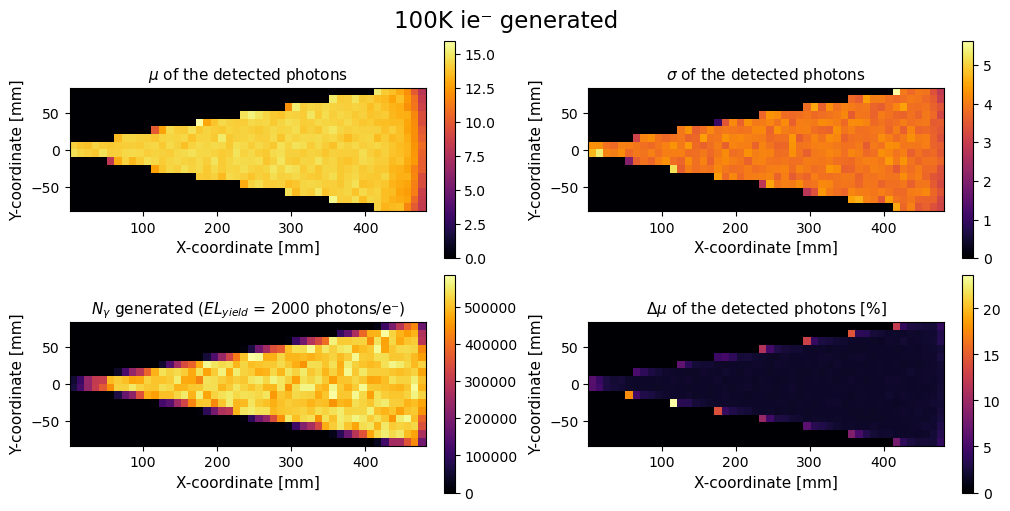

In [179]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(10,5), constrained_layout=True)

mean_map = ax[0][0].pcolormesh(xedges, yedges, mean_per_bin.T, cmap='inferno');
fig.colorbar(mean_map, ax = ax[0][0])
ax[0][0].set_title(r'$\mu$ of the detected photons', fontsize = font_size);

std_map = ax[0][1].pcolormesh(xedges, yedges, std_per_bin.T, cmap='inferno');
fig.colorbar(std_map, ax = ax[0][1])
ax[0][1].set_title(r'$\sigma$ of the detected photons', fontsize = font_size);

entries_map = ax[1][0].pcolormesh(xedges, yedges, entries_per_bin.T*yield_, cmap='inferno');
fig.colorbar(entries_map, ax = ax[1][0])
ax[1][0].set_title(r'$N_{\gamma}$ generated ($EL_{yield}$ = %s photons/e⁻)'%(yield_), fontsize = font_size);

err_map = ax[1][1].pcolormesh(xedges, yedges, mean_per_bin_err.T, cmap='inferno');
fig.colorbar(err_map, ax = ax[1][1])
ax[1][1].set_title(r'$\Delta\mu$ of the detected photons [%]', fontsize = font_size);

for row in ax:
    for axis in row:
        axis.set_xlim(xedges.min() - offset, xedges.max() + offset)
        axis.set_ylim([yedges.min() - offset, yedges.max() + offset])
        axis.set_xlabel('X-coordinate [mm]', fontsize = font_size)
        axis.set_ylabel('Y-coordinate [mm]', fontsize = font_size)
        axis.set_aspect("equal") 
        

fig.suptitle(f'{int(n_events*1e-3)}K ie⁻ generated', fontsize = 1.5*font_size);

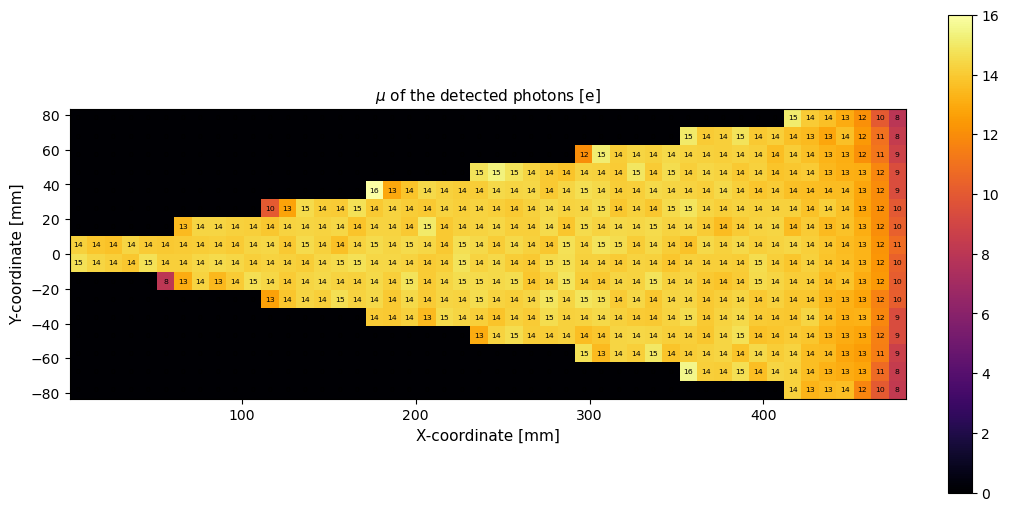

In [181]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

mean_map = ax.pcolormesh(xedges, yedges, mean_per_bin.T, cmap='inferno');
fig.colorbar(mean_map, ax = ax)
ax.set_title(r'$\mu$ of the detected photons [e]', fontsize = font_size);

ax.set_xlim(xedges.min() - offset, xedges.max() + offset)
ax.set_ylim([yedges.min() - offset, yedges.max() + offset])
ax.set_xlabel('X-coordinate [mm]', fontsize = font_size)
ax.set_ylabel('Y-coordinate [mm]', fontsize = font_size)
ax.set_aspect("equal") 

# Annotate each cell with its numeric value
for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        value = mean_per_bin[i, j]
        ax.annotate(f'{value:.0f}', ((xedges[i] + xedges[i + 1]) / 2, (yedges[j] + yedges[j + 1]) / 2),
                    color='black', ha='center', va='center', fontsize = .5*font_size)

- <p style="font-size: 17px; color: black;"> <b> Map the charge PER SENSOR vs positon hists: </b> Map in XY with a 2D histogram and in Z-axis with a 1D histogram. </p>

In [186]:
selected_sens = sens_fibers.sensor_id[0] # ID and position of the sensor we're looking at

sens_response = dst.loc[dst.sensor_id == selected_sens] # response of the selected sensor

In [189]:
# keep track of the events with no counts
no_counts_events = set(range(n_events)) - set(sens_response.event_id.unique()) 
# print(f'Events {no_counts_events} did not have any counts')

# Create a DataFrame with all event IDs
all_event_ids = pd.DataFrame({'event_id': range(n_events)})

# Merge the two DataFrames to align charge values
sens_response = all_event_ids.merge(sens_response, on='event_id', how='left').fillna(0)


In [190]:
# total charge detected by the selected sensor on each event
sens_charge = sens_response.groupby("event_id").charge.sum() 


In [191]:
# n_bins = int(np.sqrt(n_events))
n_bins = 20

bin_width = 10 # [mm]
x_nbins = int((ev_x0.max() - ev_x0.min())/bin_width)
y_nbins = int((ev_y0.max() - ev_y0.min())/bin_width)
# x_nbins = y_nbins = n_bins
bins = (x_nbins, y_nbins)

# bins = (20, 50)
font_size = 11
offset = 0.

In [194]:
# XY-plane

# Create a 2D histogram
hist, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
                                      bins=bins, 
                                      weights = sens_charge,
                                      density=False);

hist_counts, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
                                             bins=bins, 
                                             density=False);

# Calculate the mean values in each bin (normalized histogram)
hist_norm = np.where(hist_counts > 0., hist / hist_counts, 0.);


/tmp/ipykernel_549914/1692371660.py:14: RuntimeWarning: invalid value encountered in true_divide
  hist_norm = np.where(hist_counts > 0., hist / hist_counts, 0.);


In [195]:

# Initialize lists to store statistics for each bin
mean_per_bin = np.zeros((x_nbins, y_nbins))
std_per_bin = np.zeros((x_nbins, y_nbins))
entries_per_bin = np.zeros((x_nbins, y_nbins))
mean_per_bin_err = np.zeros((x_nbins, y_nbins))

# Iterate over each bin
for i in range(x_nbins):
    for j in range(y_nbins):
        # Indices of data points in the current bin
        mask = ((ev_x0 >= xedges[i]) & (ev_x0 < xedges[i + 1]) & 
                (ev_y0 >= yedges[j]) & (ev_y0 < yedges[j + 1]))
        
        # Extract values and weights in the current bin
        values_in_bin = event_charge[mask]
        
        # Calculate weighted mean and standard deviation
        mean_value = np.mean(values_in_bin)
        std_value = np.std(values_in_bin)
        entries_value = len(values_in_bin)

        # Append to lists
        mean_per_bin[i][j] = mean_value
        std_per_bin[i][j] = std_value
        entries_per_bin[i][j] = entries_value
        mean_per_bin_err[i][j] = np.where(entries_value*mean_value> 0., 
                                          std_value*100/(np.sqrt(entries_value)*mean_value), 
                                          0.)
        
mean_per_bin = np.nan_to_num(mean_per_bin)
std_per_bin = np.nan_to_num(std_per_bin)
entries_per_bin = np.nan_to_num(entries_per_bin)
mean_per_bin_err = np.nan_to_num(mean_per_bin_err)

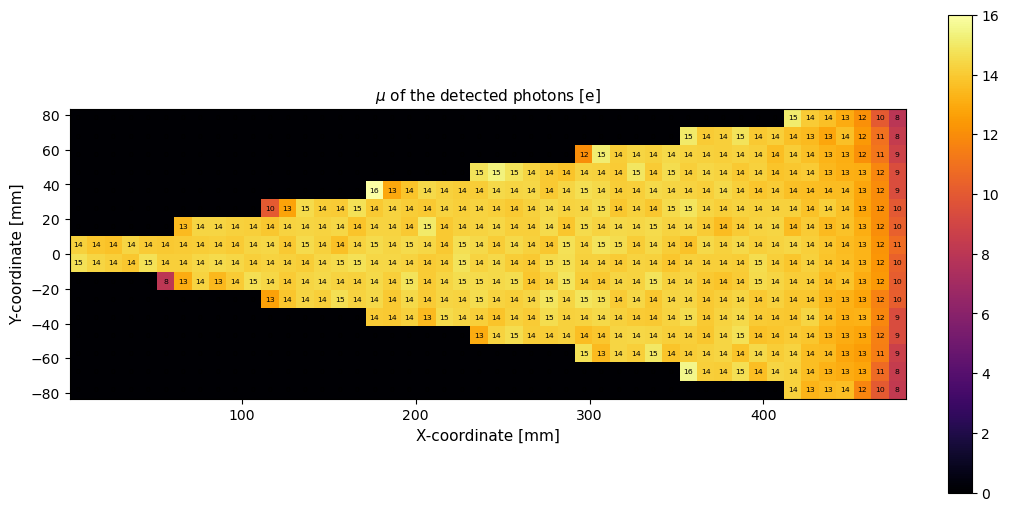

In [196]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

mean_map = ax.pcolormesh(xedges, yedges, mean_per_bin.T, cmap='inferno');
fig.colorbar(mean_map, ax = ax)
ax.set_title(r'$\mu$ of the detected photons [e]', fontsize = font_size);

ax.set_xlim(xedges.min() - offset, xedges.max() + offset)
ax.set_ylim([yedges.min() - offset, yedges.max() + offset])
ax.set_xlabel('X-coordinate [mm]', fontsize = font_size)
ax.set_ylabel('Y-coordinate [mm]', fontsize = font_size)
ax.set_aspect("equal") 

# Annotate each cell with its numeric value
for i in range(len(xedges) - 1):
    for j in range(len(yedges) - 1):
        value = mean_per_bin[i, j]
        ax.annotate(f'{value:.0f}', ((xedges[i] + xedges[i + 1]) / 2, (yedges[j] + yedges[j + 1]) / 2),
                    color='black', ha='center', va='center', fontsize = .5*font_size)

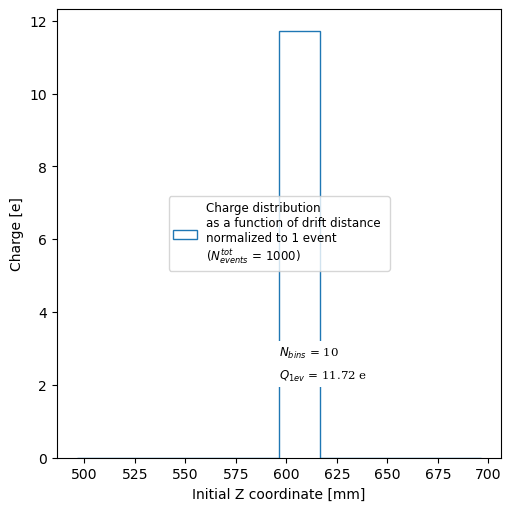

In [30]:
# Z_axis
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

# n_bins = int(np.sqrt(n_events))
n_bins = 10
font_size = 8.5

events, bins, bars = ax.hist(ev_z0, n_bins, 
                             weights = event_charge/n_events,
                             density=False,
                             range=(ev_z0.min() - 100, ev_z0.max() + 100),
                             label='Charge distribution \nas a function of drift distance \nnormalized to 1 event \n($N^{tot}_{events}$ = %s)'%(n_events), 
                             histtype='step')

ax.text(0.5, .25, r'$N_{bins}$ = %s'%(n_bins), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.text(0.5, .2, r'$Q_{1ev}$ = %.2f e'%(events.sum()), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.set_ylabel('Charge [e]')
ax.set_xlabel('Initial Z coordinate [mm]')
ax.legend(fontsize = font_size, loc = 'center');


- <p style="font-size: 17px; color: black;"> <b> Map the charge vs positon hists: </b> Map in radial and angular positions the corresponding charge. </p>

In [31]:
# Set the precision for NumPy printing
np.set_printoptions(precision=6)  # Set the desired precision

In [32]:
ev_r0 = np.sqrt(ev_x0*ev_x0 + ev_y0*ev_y0).to_numpy().round(-1)
ev_theta0 = np.degrees(np.arctan(ev_y0/ev_x0)).round(1)

In [33]:
dst_ang = {'ev_r0':ev_r0,
           'ev_theta0':ev_theta0,
           'ev_charge':event_charge
          }
dst_ang = pd.DataFrame(dst_ang)

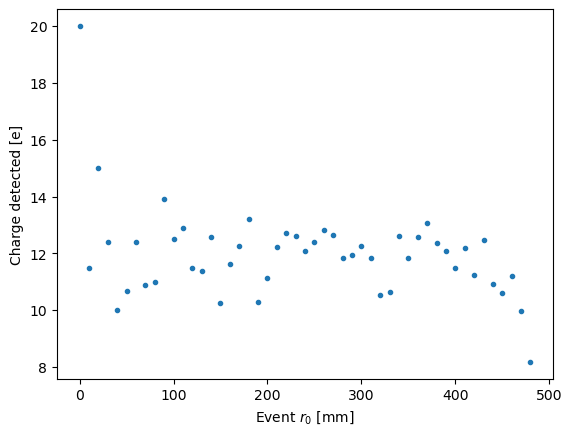

In [34]:
x_ax = dst_ang.groupby('ev_r0').mean().reset_index().ev_r0
y_ax = dst_ang.groupby('ev_r0').mean().reset_index().ev_charge


plt.plot(x_ax, y_ax, 'o', markersize = 3)
plt.xlabel(r'Event $r_0$ [mm]')
plt.ylabel('Charge detected [e]')
plt.show()

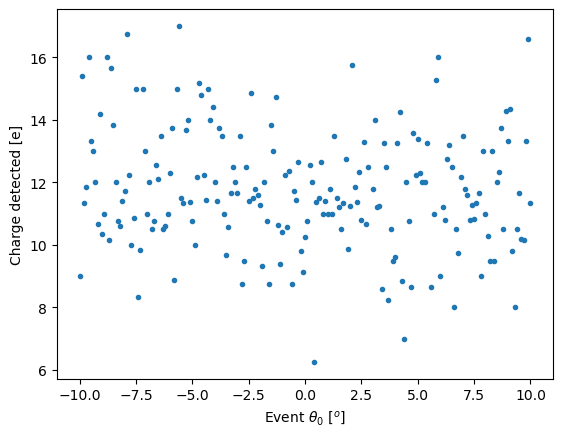

In [35]:
x_ax = dst_ang.groupby('ev_theta0').mean().reset_index().ev_theta0
y_ax = dst_ang.groupby('ev_theta0').mean().reset_index().ev_charge


plt.plot(x_ax, y_ax, 'o', markersize = 3)
plt.xlabel(r'Event $\theta_0$ [$^o$]')
plt.ylabel('Charge detected [e]')
plt.show()

- <p style="font-size: 17px; color: black;"> <b> Energy resolution: </b> . </p>

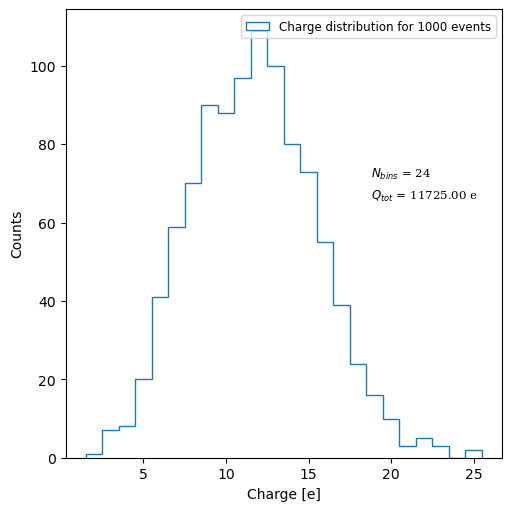

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

data = event_charge

# Determine the bin width and boundaries based on the data
bin_width = 1
min_value = min(data)
max_value = max(data)
bin_edges = np.arange(min_value - bin_width / 2, max_value + bin_width, bin_width)

font_size = 8.5

events, bins, bars = ax.hist(data, bin_edges, 
                             density=False,
                             range=(event_charge.min() - 1, event_charge.max() + 1),
                             label=f'Charge distribution for {n_events} events', 
                             histtype='step')

ax.text(0.7, .65, r'$N_{bins}$ = %s'%(len(bins) - 1), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.text(0.7, .6, r'$Q_{tot}$ = %.2f e'%(event_charge.sum()), transform = ax.transAxes,
        fontsize = font_size, verticalalignment = 'top', fontfamily = 'serif',
        bbox = dict(facecolor='1.', edgecolor = 'none', pad = 3.0))

ax.set_xlabel('Charge [e]')
ax.set_ylabel('Counts')
ax.legend(fontsize = font_size);
